# Running notes 


## Filtering 
Ice and land masking is not perfect. There are a handful of cutouts with land and more with ice. Removing them from this dataset still leaves us with 93k. Mostly ice is the problem. There are very few cutouts with land. 

In [1]:
%time x = 1
%time import math
%time sum(range(10_000))

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 6.44 μs
CPU times: user 3 μs, sys: 2 μs, total: 5 μs
Wall time: 6.91 μs
CPU times: user 118 μs, sys: 0 ns, total: 118 μs
Wall time: 124 μs


49995000

In [ ]:
import dbof.dataset_creation.zarr_dataset as zarr_dataset
import dbof.io.filesystems as filesystems

In [ ]:
import cartopy.crs as ccrs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
# follow link for a progress bar in following steps
client = Client(n_workers=8)

port = client.scheduler_info()["services"]["dashboard"]
# For nrp link is :
#https://jupyterhub-west.nrp-nautilus.io/hub/user-redirect/proxy/{port}/status
print(f"url : https://jupyterhub-west.nrp-nautilus.io/hub/user-redirect/proxy/{port}/status")

In [ ]:
client

In [ ]:
bucket = "dbof" #data_cfg["bucket"]
folder = "native_grid_dbof_training_data"
s3_endpoint = "https://s3-west.nrp-nautilus.io"
feature_channels = ['Eta', 'Salt', 'Theta', 'U', 'V', 'W', 'relative_vorticity', 'log_gradb']
run_id = "big_run_00"

fs, fs_synch = filesystems.create_s3_filesystems(s3_endpoint)

reader = zarr_dataset.ZarrDatasetReader(
    bucket=bucket,
    folder=folder,
    run_id=run_id,
    dataset_name="dataset_creation.zarr",
    fs=fs
)

In [ ]:
images_da, ids_da, valid_mask_da = reader.full_dataset_as_dask()
images_np = images_da.compute()

In [ ]:
ids_np = ids_da.compute()

In [ ]:
images_np.shape

In [ ]:
from tqdm import tqdm

# Filter land including cutouts 

In [ ]:
theta = images_np[:, 2]   # (N, 64, 64)

print("Any NaN:", np.isnan(theta).any())
print("Any +inf:", np.isposinf(theta).any())
print("Any -inf:", np.isneginf(theta).any())

print("Total NaNs:", np.isnan(theta).sum())
print("Total infs:", np.isinf(theta).sum())

# Boolean mask: True if patch has any NaN
bad_patch_mask = np.isnan(theta).reshape(theta.shape[0], -1).any(axis=1)

num_bad = bad_patch_mask.sum()
print("Number of patches containing NaN:", num_bad)

bad_indices = np.where(bad_patch_mask)[0]
print("First 10 bad patch indices:", bad_indices[:10])

In [ ]:
img = images_np[6437, 3, :,:]
print(img.shape)
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(img,origin='lower',cmap='jet')


In [ ]:
# NOTE this ruins the indexing system. 
# Image Ids need to be removed for these indexes as well todo 
N = images_np.shape[0]

keep_mask = np.ones(N, dtype=bool)
keep_mask[bad_indices] = False

images_clean_np = images_np[keep_mask]
ids_clean_np = ids_np[keep_mask]

print("Old shape:", images_np.shape)
print("New shape:", images_clean_np.shape)

# Global Analysis on our Data

Todo maybe

Global θ PDF (subsampled, log-scale)

Global summary stats (mean, std, skew, percentiles)

Per-patch mean distribution

Per-patch std distribution

Per-patch min/max distribution

Gradient magnitude distribution

2D power spectrum (radial average)

Mean θ vs latitude

Variance vs latitude

Seasonal distribution comparison (if applicable)

PCA on flattened patches (eigenvalue spectrum)

Random patch visualization (fixed color scale)

In [ ]:
def global_histogram(
    images_np,
    title,
    channel=0,
    log=True,
    bins=200
):
    """
    images_np: numpy array (N, C, H, W)
    """

    N = images_da.shape[0]

    #patch_idx = np.random.choice(N, size=min(n_patches, N), replace=False)

    samples = []

    # for i in tqdm(patch_idx):
    for i in tqdm(range(len(images_np))):
        # Only compute one patch at a time
        patch = images_np[i, channel]  # (64,64)

        flat = patch.ravel()
        samples.append(flat)

    samples = np.concatenate(samples)
    print(samples[0])

    print(f"Total sampled points: {samples.size}")
    print(f"Mean: {samples.mean():.3f}")
    print(f"Std: {samples.std():.3f}")
    print(f"1–99 percentile: {np.percentile(samples,[1,99])}")

    plt.figure(figsize=(6,4))
    plt.hist(samples, bins=bins, density=True, log=log)
    plt.xlabel("Theta")
    plt.ylabel("PDF (log scale)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

## Theta

In [ ]:
theta = images_clean_np[:, 2]   # (N, 64, 64)

In [ ]:
global_histogram(images_clean_np,"Theta Pdf", channel=2,log=False, bins=300)

# Filter out ice patches

In [ ]:
# ice???
bad_mask = (theta <= 0).any(axis=(1, 2))

count = bad_mask.sum()
ice_indices = np.where(bad_mask)[0]

print(count)
print(ice_indices[:10])

In [ ]:
img = images_np[52, 2, :,:]
print(img.shape)
plt.figure(figsize=(8,8), dpi= 90)

im = plt.imshow(img, origin='lower', cmap='jet')
plt.colorbar(im)   # attach colorbar to this image

plt.show()

In [ ]:
# NOTE this ruins the indexing system. 
# Image Ids need to be removed for these indexes as well todo 
N = images_clean_np.shape[0]

keep_mask = np.ones(N, dtype=bool)
keep_mask[ice_indices] = False

images_clean_no_ice_np = images_clean_np[keep_mask]
ids_clean_no_ice_np = ids_clean_np[keep_mask]

print("Old shape:", images_clean_np.shape)
print("New shape:", images_clean_no_ice_np.shape)

In [ ]:
global_histogram(images_clean_no_ice_np,"Theta Pdf", channel=2,log=False, bins=300)

# Eta

100%|██████████| 93564/93564 [00:00<00:00, 1920767.55it/s]


-0.33670318
Total sampled points: 383238144
Mean: 0.244
Std: 0.654
1–99 percentile: [-1.395239    1.69835269]


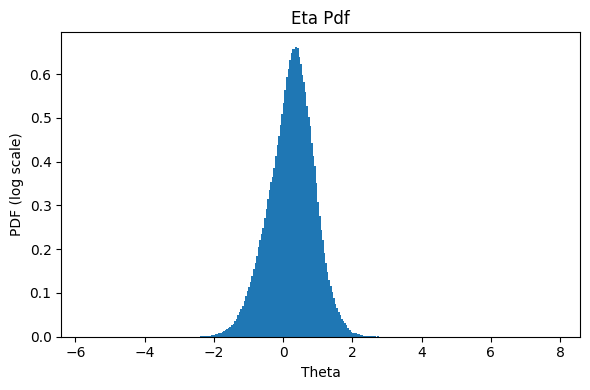

In [22]:
global_histogram(images_clean_no_ice_np,"Eta Pdf", channel=0,log=False, bins=300)

# Salinity

100%|██████████| 93564/93564 [00:00<00:00, 1879653.13it/s]


33.66996
Total sampled points: 383238144
Mean: 34.464
Std: 1.701
1–99 percentile: [29.28880392 36.88170242]


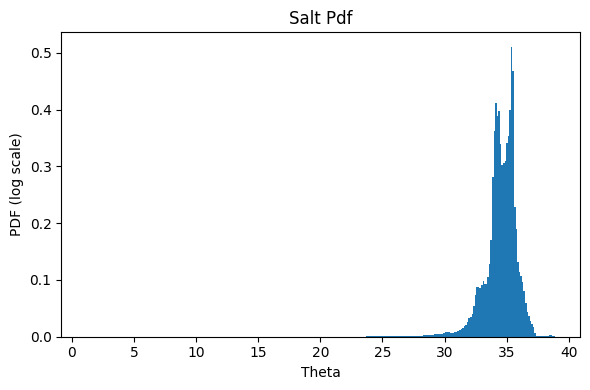

In [23]:
global_histogram(images_clean_no_ice_np,"Salt Pdf", channel=1,log=False, bins=300)

# Vorticity

100%|██████████| 93564/93564 [00:00<00:00, 1893931.48it/s]


2.5418722e-06
Total sampled points: 383238144
Mean: nan
Std: nan
1–99 percentile: [nan nan]


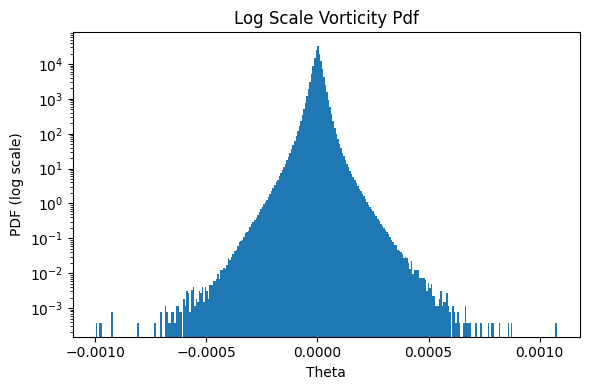

In [24]:
global_histogram(images_clean_no_ice_np,"Log Scale Vorticity Pdf", channel=6,log=True, bins=300)

# B

100%|██████████| 93564/93564 [00:00<00:00, 1884111.15it/s]


-19.038826
Total sampled points: 383238144
Mean: nan
Std: nan
1–99 percentile: [nan nan]


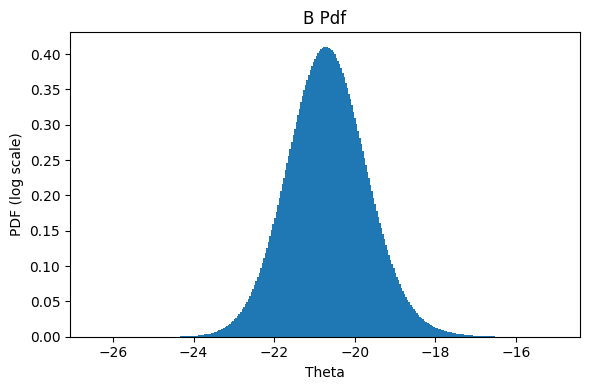

In [25]:
global_histogram(images_clean_no_ice_np,"B Pdf", channel=7,log=False, bins=300)

In [9]:
files = fs_synch.glob(
    f"{bucket}/{folder}/{run_id}/metadata/*.parquet"
)

meta_df = pd.read_parquet(files, filesystem=fs_synch)

/home/jovyan/conda_envs/dbof_training/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


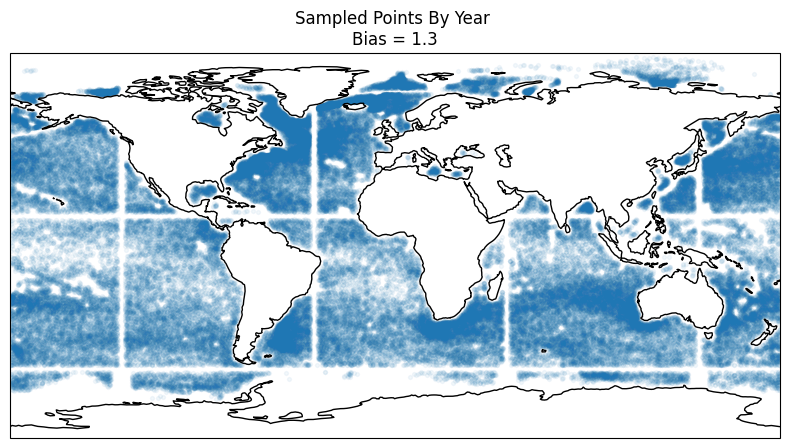

In [10]:
lats = meta_df["center_lat"].values
lons = meta_df["center_lon"].values


cmap = plt.get_cmap("tab10")

fig = plt.figure(figsize=(11, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()
ax.coastlines()

sc = ax.scatter(
    lons,
    lats,
    cmap=cmap,
    s=8,
    alpha=0.05,
    transform=ccrs.PlateCarree()
)

plt.title("Sampled Points By Year \nBias = 1.3")
plt.show()

In [14]:
pd.Series(meta_df["time_snapshot"].unique()).to_csv("unique_timestamps_data00.csv", index=False)

In [29]:
meta_df[meta_df["dataset_index"] == ids_clean_no_ice_np[0]].center_lat.values[0]

np.float64(41.217994689941406)

In [30]:
def get_valid_lats_and_mask_for_metadata(ds):
    lookup = meta_df.drop_duplicates("dataset_index").set_index("dataset_index")["center_lat"]

    ids = pd.Index(ids_clean_no_ice_np)
    lats = lookup.reindex(ids).to_numpy()          # NaN where missing
    keep = ~np.isnan(lats)

    return lats, keep

In [31]:
def mean_value_by_latitude_vector(channel, ds, lats, keep, label):
    means = []
    for value in tqdm(np.asarray(ds, dtype=object)[keep]):
        means.append(float(value[channel].mean()))     # xarray scalar -> float

    plt.scatter(lats[keep], means, s=10, alpha=0.5)
    plt.xlabel("Latitude (degrees)")
    plt.ylabel("Mean per cutout")
    plt.title(label)
    # plt.bar(lats[keep], means)

    # plt.xlabel("Latitude Degrees")
    # plt.ylabel(f"Mean per cutout")
    # plt.title(label)
    # plt.legend()

In [32]:
def mean_value_histogram(channel, ds, keep, bins, log, label):
    
    means = []
    for value in tqdm(np.asarray(ds, dtype=object)[keep]):
        means.append(float(value[channel].mean()))     # xarray scalar -> float

    
    plt.figure(figsize=(6,4))
    plt.hist(means, bins=bins, density=True, log=log)
    plt.xlabel("Mean Value")
    plt.ylabel("PDF")
    plt.title(label)
    plt.tight_layout()
    plt.show()

In [33]:
lats, keep = get_valid_lats_and_mask_for_metadata(images_clean_no_ice_np)

100%|██████████| 93524/93524 [00:08<00:00, 10940.28it/s]


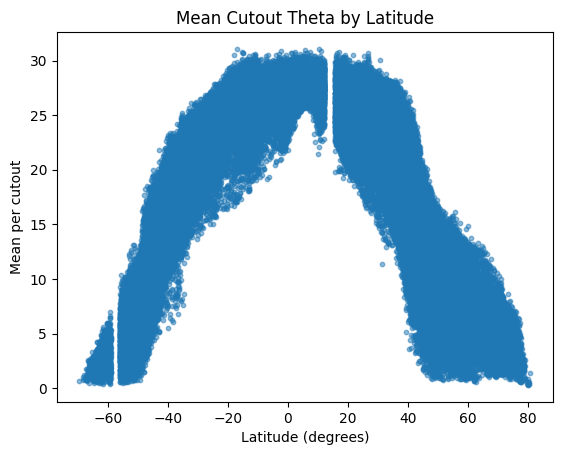

In [34]:
mean_value_by_latitude_vector(2, images_clean_no_ice_np, lats, keep, label="Mean Cutout Theta by Latitude")

100%|██████████| 93524/93524 [00:06<00:00, 15105.37it/s]


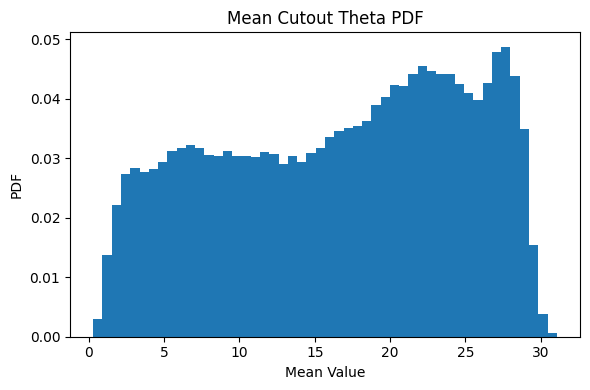

In [37]:
mean_value_histogram(2, images_clean_no_ice_np, keep, 50, False, "Mean Cutout Theta PDF")

100%|██████████| 93524/93524 [00:05<00:00, 16917.90it/s]


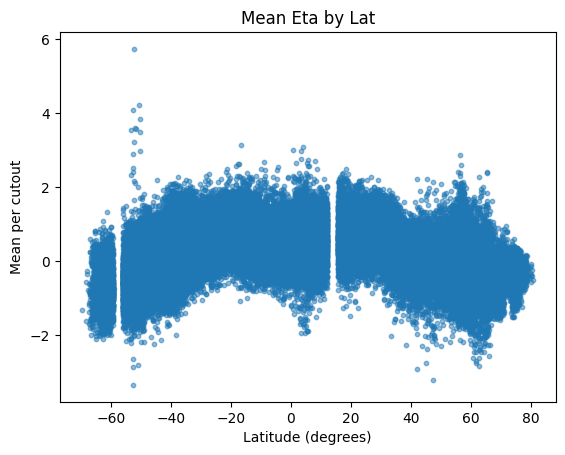

In [38]:
mean_value_by_latitude_vector(0, images_clean_no_ice_np, lats, keep, label="Mean Eta by Lat")

100%|██████████| 93524/93524 [00:07<00:00, 12978.33it/s]


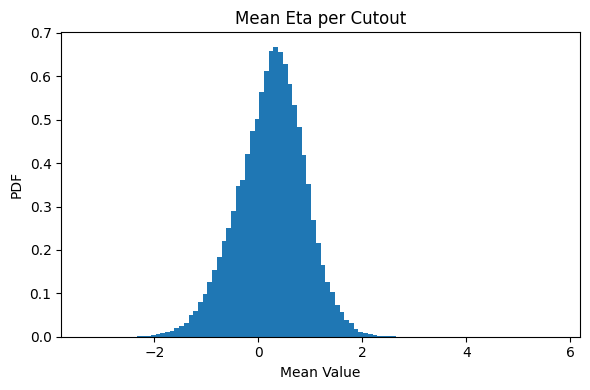

In [40]:
mean_value_histogram(0, images_clean_no_ice_np, keep, 100, False, "Mean Eta per Cutout")

100%|██████████| 93524/93524 [00:07<00:00, 12942.73it/s]


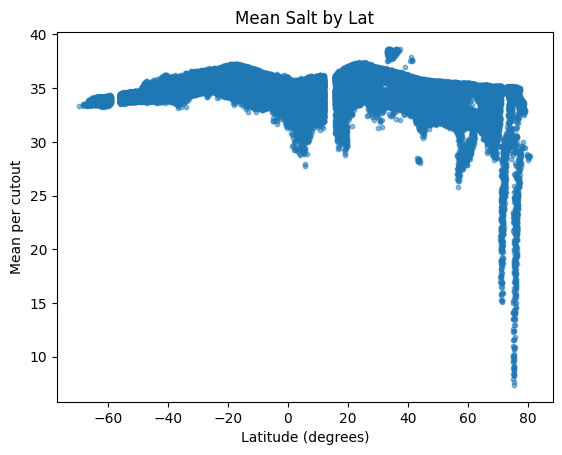

In [41]:
mean_value_by_latitude_vector(1, images_clean_no_ice_np, lats, keep, label="Mean Salt by Lat")

100%|██████████| 93524/93524 [00:07<00:00, 13291.81it/s]


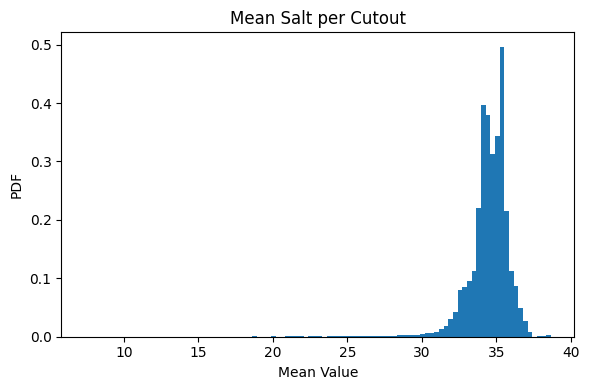

In [42]:
mean_value_histogram(1, images_clean_no_ice_np, keep, 100, False, "Mean Salt per Cutout")

100%|██████████| 93524/93524 [00:07<00:00, 12661.76it/s]


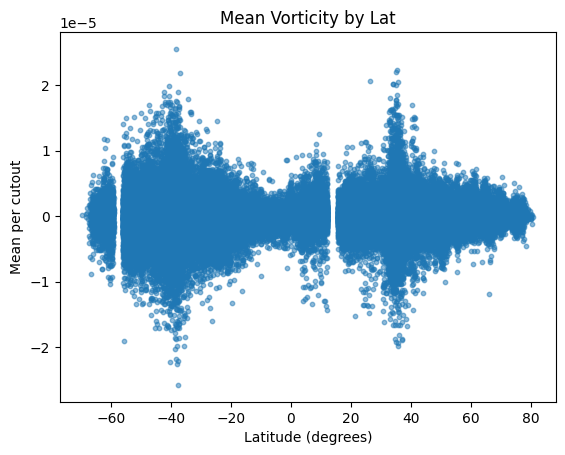

In [43]:
mean_value_by_latitude_vector(6, images_clean_no_ice_np, lats, keep, label="Mean Vorticity by Lat")

100%|██████████| 93524/93524 [00:07<00:00, 12695.35it/s]


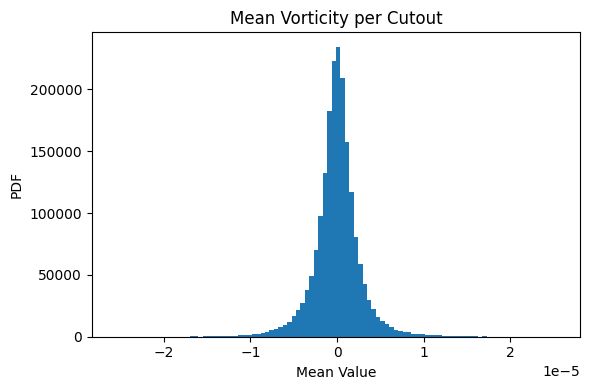

In [44]:
mean_value_histogram(6, images_clean_no_ice_np, keep, 100, False, "Mean Vorticity per Cutout")

100%|██████████| 93524/93524 [00:04<00:00, 19599.57it/s]


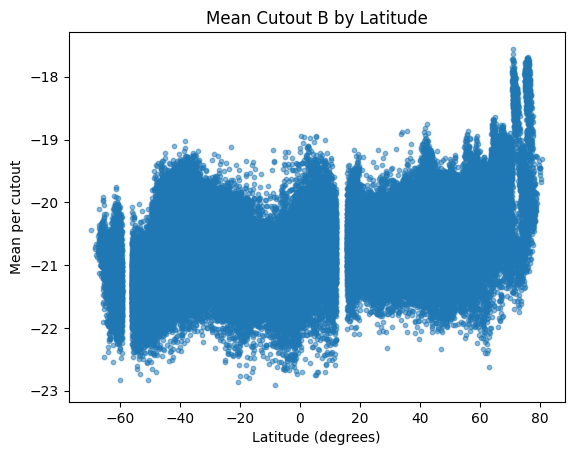

In [58]:
mean_value_by_latitude_vector(7, images_clean_no_ice_np, lats, keep, label="Mean Cutout B by Latitude")

100%|██████████| 93524/93524 [00:04<00:00, 19290.00it/s]


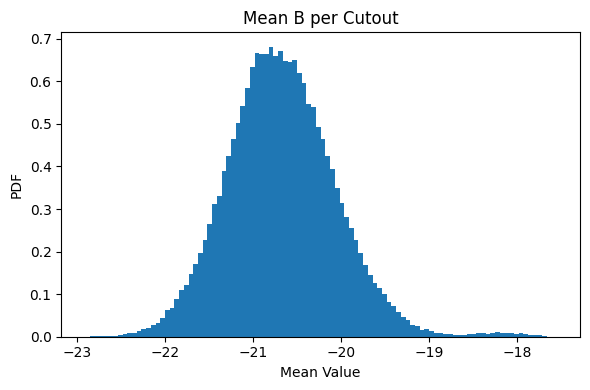

In [45]:
mean_value_histogram(7, images_clean_no_ice_np, keep, 100, False, "Mean B per Cutout")

# Covariance 

In [61]:
band_count = images_clean_no_ice_np.shape[1]
print(f"Count of Bands : {band_count}\n")
bands_stacked = [0]*(band_count)

for band_i in range(band_count):
    print(f"Stacking Band {feature_channels[band_i]}")
    bands_stacked[band_i] = np.stack([cutout[band_i] for cutout in images_clean_no_ice_np])
    
    print(f"Shape : {bands_stacked[band_i].shape}\n")  # (N, 64, 64)

Count of Bands : 8

Stacking Band Eta
Shape : (93564, 64, 64)

Stacking Band Salt
Shape : (93564, 64, 64)

Stacking Band Theta
Shape : (93564, 64, 64)

Stacking Band U
Shape : (93564, 64, 64)

Stacking Band V
Shape : (93564, 64, 64)

Stacking Band W
Shape : (93564, 64, 64)

Stacking Band relative_vorticity
Shape : (93564, 64, 64)

Stacking Band log_gradb
Shape : (93564, 64, 64)



In [63]:
# Reshape to (Bands, N * 64 * 64)
np_bands_stacked = np.array(bands_stacked)
print(np_bands_stacked.shape)
reshaped = np_bands_stacked.reshape((np_bands_stacked.shape[0],-1))
print(reshaped.shape)
# Each row is now a band, all pixels across all images

cov_matrix = np.cov(reshaped)
cov_df = pd.DataFrame(cov_matrix, index=feature_channels, columns=feature_channels)

(8, 93564, 64, 64)
(8, 383238144)


NameError: name 'tabulate' is not defined

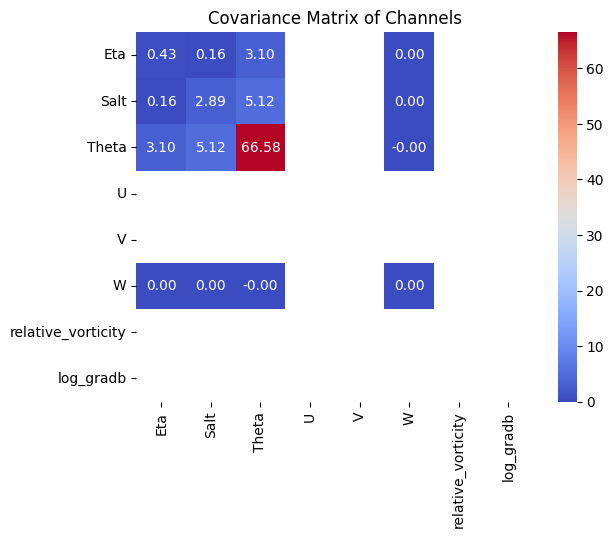

In [67]:
import seaborn as sns
sns.heatmap(cov_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Covariance Matrix of Channels")
plt.show()

In [ ]:
import cmocean


def plot_image_features(imgs, ids):r
    """
    imgs: (N, C, H, W)
    """

    N, C, H, W = imgs.shape

    fig = plt.figure(figsize=(2.5*(C+1), 2.5*N))
    gs = fig.add_gridspec(N, C + 1, wspace=0.5, hspace=0.15)

    for i in range(N):
        row_data = imgs[i]

        for c in range(C):
            ax = fig.add_subplot(gs[i, c])

            # vmin = np.nanmin(row_data[c])
            # vmax = np.nanmax(row_data[c])


            if c == 0:
                cmap = cmocean.cm.gray
            elif c == 1 :
                cmap = cmocean.cm.haline
            elif c == 2 :
                cmap = cmocean.cm.thermal
            elif c == 6 :
                cmap = cmocean.cm.diff
            else :
                cmap = cmocean.cm.speed



            im = ax.imshow(row_data[c], cmap=cmap) #, vmin=vmin, vmax=vmax)
            ax.set_xticks([])
            ax.set_yticks([])

            if i == 0:
                ax.set_title(f"{feature_channels[c]}", fontsize=10)

            fig.colorbar(
                im,
                ax=ax,
                fraction=0.046,
                pad=0.01 #format="%4.2"
            )

    plt.show()

rand_indices = np.random.randint(0, reader.num_images, size=4)
imgs, ids = reader.get_images(rand_indices)

plot_image_features(imgs, ids)

# Metadata for each sample
subset_df = (
    meta_df
    .set_index("dataset_index")
    .loc[ids]
    .reset_index()
)
subset_df